<h1><center><b>Εκπαίδευση Μοντέλου Μηχανικής Μάθησης</b></center></h1>

Στη παρούσα φάση έχουμε δημιουργήσει τα δεδομένα με τα οποία θα εκπαιδεύσουμε και θα αξιολογήσουμε το μοντέλο μηχανικής μάθησης. Ήρθε λοιπόν η ώρα να δημιουργήσουμε αυτό το μοντέλο και να το εκπαιδεύσουμε με τα δεδομένα μας.

Για τη __δημιουργία__ και __εκπαίδευση__ του μοντέλου, θα χρησιμοποιήσουμε το εργαλείο [PyTorch][pytorch_link] της Python, μία __βιβλιοθήκη__ ειδικά σχεδιασμένη για __τεχνητή νοημοσήνη__, η οποία περιέχει χρήσιμα _εργαλεία_ και απαραίτητους _αλγορίθμους_ __μηχανικής μάθησης__.

<center><img src="https://assets-global.website-files.com/5f6bc60e665f54db361e52a9/637f8955a0d9698c6d768464_pytorch-logo.jpeg" width=500></center>

[pytorch_link]: https://pytorch.or

## Αναπαραγωγιμότητα (Reproducibility)

Αρχικά θα φροντίσουμε να πληρείται το φαινόμενο της [__αναπαραγωγιμότητας__][reproducibility_link] (reproducibility), το οποίο συνεπάγεται στο ότι κάθε φορά θα έχουμε τις __ίδιες__ ακριβώς __συνθήκες__ κατά τη διαδικασία __εκπαίδευσης__ του μοντέλου. Αυτό σημαίνει πως η __αρχικοποίηση__ των __βαρών__ και η __σειρά__ των δεδομένων στα _batches_ θα να είναι κάθε φορά ίδια, ώστε η επίδοση του νευρωνικού δικτύου που θα κατασκευάσουμε, να μην εξαρτάται από κάποιο καλύτερο __σημείο αρχικοποίησης__ ή κάποια __ευνοϊκότερη διαχείριση__ των δεδομένων. Για το λόγο αυτό θα χρησιμοποιήσουμε _συγκεκριμένη μήτρα τυχαιότητας_ για όλες τις απαραίτητες βιβλιοθήκες και αλγορίθμους ως εξής:

[reproducibility_link]: https://blog.ml.cmu.edu/2020/08/31/5-reproducibility/

In [1]:
import os
import torch
import numpy as np
import random

seed = 23472642 # Set the seed

def initialize_seed():
    """ Initializes the seed for later use """

    # Apply the seed to Numpy and Random modules
    np.random.seed(seed)
    random.seed(seed)

    # Apply the seed to PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Set the operating system python seed
    os.environ['PYTHONHASHSEED'] = str(seed)

Την παραπάνω συνάρτηση θα τη χρησιμοποιούμε κάθε φορά που θέλουμε να εκπαιδεύσουμε ένα μοντέλο μηχανικής μάθησης.

## Σύνδεση σε συσκευή CPU ή GPU (CUDA) 🔗

Στη συνέχεια θα φροντίσουμε να χρησιμοποιήσουμε την κατάλληλη __συσκευή__ __CPU__ ή __GPU__ του τοπικού μας υπολογιστή. Αξίζει να αναφερθεί πως η χρήση __GPU__ σε αυτό το σημείο είναι αναπόφεχτη καθώς οι διάφοροι αλγόριθμοι που θα εκτελέσουμε αργότερα απαιτούν μεγάλο __υπολογιστικό φόρτο__ με αποτέλεσμα να έχουν __μεγάλο χρόνο__ διάρκειας η εκτέλεσή τους. Επομένως εάν έχετε διαθέσιμη GPU στον υπολογιστή σας, φροντίστε να την αξιοποιήσετε.

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Pytorch connected to {device}')

Pytorch connected to cuda


## Βοηθητικές Προσθήκες ➕✅

Για άλλη μία φορά θα ορίσουμε μερικές βοηθητικές προσθήκες για την συνέχεια.

In [3]:
import os
from graphics import *

def resource_path(relative_path):
    """ Supporting function to receive the full path of a destination, on the current system. Provided from: 
        https://stackoverflow.com/questions/31836104/pyinstaller-and-onefile-how-to-include-an-image-in-the-exe-file """
    
    try:
        base_path = sys._MEIPASS2
    except Exception:
        base_path = os.path.abspath(".")

    return os.path.join(base_path, relative_path)

invert_colors = False # Change the value according to your preferences

custom_cmap = invert_colormap if invert_colors else get_colormap
custom_hex_color = invert_hex_color if invert_colors else get_hex_color

## Φόρτωση Δεδομένων (Mel-Spectrograms)

Στη συνέχεια θα φορτώσουμε τα δεδομένα μας και θα τα αποθηκεύσουμε σε __κετάλληλες δομές__. Ας ξεκινήσουμε αρχικοποιώντας τα __μονοπάτια__ στα οποία βρίσκονται τα δεδομένα μας.

In [4]:
# Define base, and data folder path
base_folder = resource_path('../')
data_folder = base_folder + 'Data/Spectrograms'

print('Data are located to: ' + data_folder)

Data are located to: E:\Antonis\Programming\Python\MyProjects\AI - Machine Learning\Music_Identifier\Notebooks\../Data/Spectrograms


Αφού αρχικοποιήσουμε τους φακέλους στους οποίους βρίσκονται τα δεδομένα μας, ας αποθηκεύσουμε τα μονοπάτια των __αρχείων__ που περιέχουν τα δεδομένα.

In [5]:
# Store the data and label files
data_file = data_folder + '/data.npy'
labels_file = data_folder + '/labels.npy'

print('Data are located to: ' + data_file)
print('Labels are located to: ' + labels_file)

Data are located to: E:\Antonis\Programming\Python\MyProjects\AI - Machine Learning\Music_Identifier\Notebooks\../Data/Spectrograms/data.npy
Labels are located to: E:\Antonis\Programming\Python\MyProjects\AI - Machine Learning\Music_Identifier\Notebooks\../Data/Spectrograms/labels.npy


Έχοντας στα χέρια μας τα αρχεία που περιέχουν τα δεδομένα μας ας τα φορτώσουμε στο project και ας τα αποθηκεύσουμε. Θα δουλέψουμε με τα πρώτα 1000 δείγματα των δεδομένων.

In [6]:
import numpy as np

# Load the spectrograms and the labels
data = np.load(data_file)[:1000]
labels = np.load(labels_file)[:1000]

## Διαχωρισμός των δεδομένων σε training, validating, και testing 📤⚙️

Για να μπορέσουμε να εκπαιδεύσουμε το μοντέλο μας, θα πρέπει να __χωρίσουμε__ τα δεδομένα μας σε δεδομένα __εκπαίδευσης__ (training), __επικύρωσης__ (validating) και __αξιολόγησης__ (testing). Για τον λόγο αυτό θα χρησιμοποιήσουμε την έτοιμη συνάρτηση `train_test_split()` της βιβλιοθήκης [Scikit-learn][sklearn_link], η οποία έχει σχεδιαστεί γι' αυτόν ακριβώς τον σκοπό. Σε ένα πρόβλημα μηχανικής μάθησης οφείλουμε να διαχωρίσουμε τα δεδομένα μας σε train και αξιοόγησης με τέτοιο τρόπο που να πετυχαίνουμε όσο το δυνατό καλύτερες επιδόσεις. Μία καλή διαμέριση των δεδομένων είναι __70-80% training data__ και __20-30% testing data__. Παρομοίως τα validating data οφείλουν να αποτελούν περίπου το __20-30%__ των __δεδομένων εκπαίδευσης__.

[sklearn_link]: https://scikit-learn.org/stable/

In [7]:
from sklearn.model_selection import train_test_split

# Split the data to training, validating and testing data.
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.20)

print(f'Testing Data: {len(test_data)/len(data)*100:.02f}%')
print(f'Training Data: {len(train_data)/len(data)*100:.02f}%')
print(f'Validating Data: {len(val_data)/len(data)*100:.02f}%')

Testing Data: 20.00%
Training Data: 64.00%
Validating Data: 16.00%


Στο παραπάνω τμήμα κώδικα το __20%__ όλων των δεδομένων αποτελούνται από __testing data__ και το __20%__ των __training data__ αποτελείται από __validating data__. Ας οπτικοποιήσουμε αυτές τις διαμερίσεις για να τις καταλάβουμε καλύτερα.

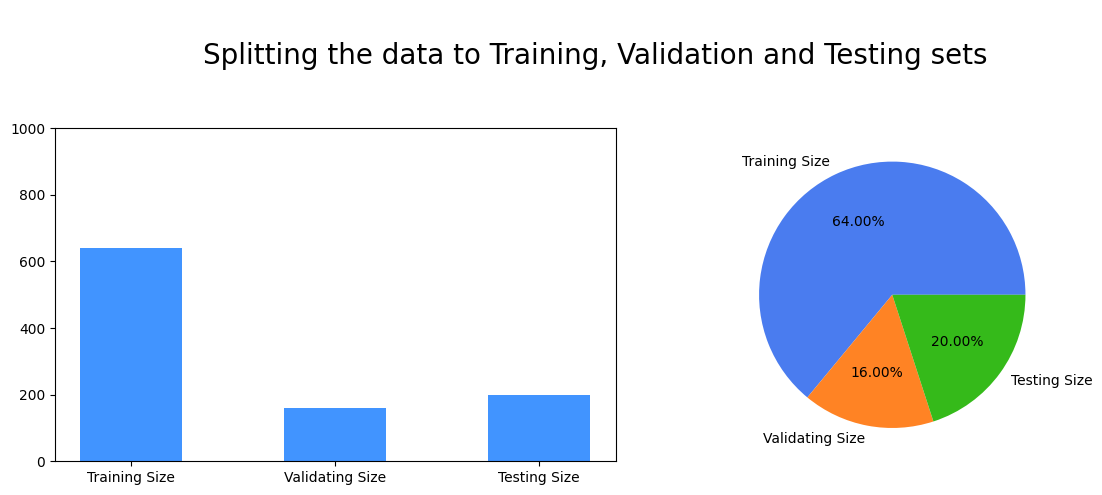

In [8]:
from matplotlib import pyplot as plt

train_size, val_size, test_size = len(train_data), len(val_data), len(test_data)
plot_percentages = [train_size, val_size, test_size] 
plot_labels = ['Training Size', 'Validating Size', 'Testing Size']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(plot_labels, plot_percentages, width=0.5, color=custom_hex_color('#4194FF'))
axes[0].set_ylim(0, len(data))

axes[1].pie(plot_percentages, labels=plot_labels, autopct='%1.2f%%', wedgeprops={'linewidth': 0.3},
            colors=[custom_hex_color('#4A7CEF'), custom_hex_color('#FF8324'), custom_hex_color('#35BA1A')])

fig.suptitle('\nSplitting the data to Training, Validation and Testing sets\n', fontsize=20)
plt.tight_layout()
plt.show()

Όπως είπαμε θα χρησιμοποιήσουμε τη βιβλιοθήκη __PyTorch__ της Python. Γι' αυτό το λόγο στη συνέχεια θα δημιουργήσουμε μία δικιά μας κλάση `MusicDataset` η οποία θα κληρονομεί την κλάση `Dataset` της __PyTorch__ και θα υλοποιεί τις απαραίτητες μεθόδους.

In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset

class MusicDataset(Dataset):
    """ Class that represents a music dataset extending the PyTorch Dataset """

    # Static Labels Transformation dictionaries
    LABEL_TRANSFORMATION_DICT = {0: 'classical', 1: 'hiphop', 2: 'rock', 3: 'blues'}
    LABEL_TRANSFORMATION_DICT_INVERT = {'classical': 0, 'hiphop': 1, 'rock': 2, 'blues': 3}

    def __init__(self, data: np.array, labels: np.array) -> None:
        """ Constructor of the Music Dataset. Initializes the data and the labels. """

        self.data = data
        self.labels = labels

        self.__transform_labels() # Make sure our labels are transformed into numbers

    def __transform_labels(self) -> None:
        """ Tranforms the labels of the dataset by changing the text into integer. """

        self.labels = np.array([MusicDataset.LABEL_TRANSFORMATION_DICT_INVERT[category] for category in self.labels])

    def __len__(self) -> int:
        """ Returns the length of the Dataset. """

        return len(self.data)

    def __getitem__(self, index: int) -> tuple[torch.tensor, torch.tensor]:
        """ Returns the data and label located at the given index inside the Dataset. """

        data_item = self.data[index]
        label_item = self.labels[index]

        return torch.tensor(data_item, dtype=torch.float32), torch.tensor(label_item, dtype=torch.long)

Στην παραπάνω υλοποίηση της κλάσης `MusicDataset` φροντίζουμε και __μετατρέπουμε__ τα αποθηκευμένα __labels__ σε __ακέραιους αριθμούς__ έτσι ώστε το νευρωνικό μας δίκτυο να μπορέσει να δουλέψει μόνο με νούμερα. Αυτό το επιτυγχάνουμεμε τη μέθοδο `__transform_labels()` η οποία καλείται με το δημιουργήσουμε κάποιο αντικείμενο της κλάσης. Συγκεκριμένα η αντιστοίχιση των labels σε ακέραιους αριθμούς γίνεται ως εξής:

* 0 $\rightarrow$ classical
* 1 $\rightarrow$ hiphop
* 2 $\rightarrow$ rock_metal_hardrock
* 3 $\rightarrow$ blues

Έχοντας ορίσει την κλάση `MusicDataset`, ας δημιουργήσουμε **3 αντικείμενα** αυτής της κλάσης τα οποία θα αναπαριστούν τα training, validating, και testing data που έχουμε στην κατοχή μας.

In [10]:
# Define our datasets
train_dataset = MusicDataset(train_data, train_labels)
val_dataset = MusicDataset(val_data, val_labels)
test_dataset = MusicDataset(test_data, test_labels)

Τέλος έχοντας ορίσει τα datasets μας, ας δημιουργήσουμε τα 3 [__Pytorch DataLoaders__][dataloder_link] (ένα για κάθε σύνολο δεδομένων) με `batch_size=16`, ώστε να μπορούν να χρησιμοποιηθούν στο μοντέλο μας. Θα δώσουμε επίσης το όρισμα `shuffle=True` για τα **train data** και **validation data**.

[dataloder_link]: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [11]:
from torch.utils.data import DataLoader

g_cpu = torch.Generator(device='cpu') # Create our generator

# Construct our Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator=g_cpu)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, generator=g_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, generator=g_cpu)

<hr>

## Ορισμός Μοντέλου - Νευρωνικό Δίκτυο (Neural network) 🤖🧠

Σε αυτό το project θα ασχοληθούμε συγκεκριμένα με [__συνελικτικά νευρωνικά δίκτυα__][cnn_link] (Convolutional Neural Networks). Τα __Convolutional Neural Networks__ (CNNs) είναι ιδανικά για την __εξαγωγή__ συγκεκριμένων __χαρακτηριστικών__ και __μοτίβων__ από τα δεδομένα που τους δίνουμε ως είσοδο, και ως αποτέλεσμα μαθαίνει από αυτά.

<center><img src="https://saturncloud.io/images/blog/a-cnn-sequence-to-classify-handwritten-digits.webp" width=900></center>

[cnn_link]: https://en.wikipedia.org/wiki/Convolutional_neural_network

### Παράμετροι Μοντέλου

Συγκεκριμένα για το δικό μας μοντέλο __συνελικτικού νευρωνικού δικτύου__ (CNN) θα ισχύουν τα εξής:

* Θα αποτελείται από μία ακολουθία [__τεσσάρων συνελικτικών επιπέδων__][layer_link], με __kernel size 5__, ώστε να επιτυγχάνεται η εξής ακολουθία καναλιών: 1, 16, 32, 64, 128

* Η __έξοδος__ του __τελευταίου συνελικτικού επιπέδου__ είναι η __είσοδος__ ενός [__πλήρους συνδεδεμένου νευρωνικού δικτύου__][fcnn_link] (FCNN) με 4 επίπεδα με αριθμό νευρώνων __x__, (όπου x είναι η διάσταση εξόδου του συνελικτικού δικτύου), __1024__, __256__, __32__ και __out_dim__, όπου out_dim=4 διότι έχουμε 4 κατηγορίες μουσικής.

Σύμφωνα με τις παραπάνω προδιαγραφές ας ορίσουμε το νευρωνικό μας δίκτυο

[layer_link]: https://www.sciencedirect.com/topics/engineering/convolutional-layer#:~:text=2.3.-,1%20Convolutional%20layer,and%20creates%20an%20activation%20map
[fcnn_link]: https://www.gabormelli.com/RKB/Fully-Connected_Neural_Network

In [12]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CNN_Music_Identifier_Model(nn.Module):
    """ Class that represents a Convolution Neural Network designed for idetifying music category. """
    
    KERNEL_SIZE = 5
    
    def __init__(self):
        """ Constructor of the Convolutional neural network. """
        
        super(CNN_Music_Identifier_Model, self).__init__() # Initialize the neural network module
        
        # Initialize the Convolutional Layers of the the network
        self.conv1 = nn.Conv2d(1, 16, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv2 = nn.Conv2d(16, 32, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv3 = nn.Conv2d(32, 64, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv4 = nn.Conv2d(64, 128, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        
        # Define the pooling method
        self.max_pool = nn.MaxPool2d(2, 2)
        
        # Initialize the Fully Connected Layers of the network
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)
        
        # Build the convolutional and fully connected layers' connection sequence
        self.conv_sequence = nn.Sequential(
            self.conv1, self.max_pool,
            self.conv2, self.max_pool,
            self.conv3, self.max_pool,
            self.conv4, self.max_pool,
        )
        self.fc_sequence = nn.Sequential(self.fc1, self.fc2, self.fc3, self.fc4)
        
    def forward(self, x):
        """ Forward method of the neural network """
        
        # Apply the convolutional layers
        x = torch.unsqueeze(x, 1)
        x = self.conv_sequence(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Apply the fully connected layers
        x = self.fc_sequence(x)
        
        return x

<hr>

## Εκπαίδευση και Αξιολόγηση Μοντέλου (Model Training and Testing)

### Εκπαίδευση (Training)

Έχοντας ορίσει το μοντέλο μας, θα πρέπει να το __εκπαιδεύσουμε__ δίνοντάς του ως είσοδο τα __δεδομένα εκπαίδευσης__. Ακολουθεί μία __συνάρτηση__ της οποίας ο κύριος σκοπός είναι η [__εκπαίδευση__][train_link] του μοντέλου για __1 εποχή__ (1 επανάληψη).

[train_link]: https://towardsdatascience.com/how-do-we-train-neural-networks-edd985562b73

In [13]:
def train_for_one_epoch(optimizer, dataloader, criterion, nn_model):
    """ Trains the given model with the given parameters for one epoch. Also
        returns the final trained model after the training process, and the training loss. """
    
    dataloader.generator.manual_seed(seed  + epoch)
    
    nn_model.train() # Set the model to training mode
    total_loss = 0.0
    
    for batch, (data, labels) in enumerate(dataloader):
        
        # Move the batch data and the labels to the device used at that time
        data, labels = data.to(device), labels.to(device)
        
        # Compute the predicted labels and get the loss
        predicted_labels = nn_model(data)
        loss = criterion(predicted_labels, labels)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the training loss
        total_loss += loss.item() * data.size(0)
        
    average_training_loss = total_loss / len(dataloader.dataset)
        
    return nn_model, average_training_loss

Έχοντας ορίσει τη διαδικασία εκπαίδευσης του δικτύου, ας ορίσουμε ένα __στιγμιότυπο__ της κλάσης `CNN_Music_Identifier_Model` και ας το εκπαιδεύσουμε για __30 εποχές__ και θα έχουμε τα εξής χαρακτηριστικά:

* **Optimizer**: [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD)
* **Learning Rate**: 0.001
* **Loss Function**: [Cross-Entropy Loss](https://en.wikipedia.org/wiki/Cross-entropy)
* **Αριθμός Εποχών** (Epochs): 200

In [14]:
import torch.nn as nn
import torch.optim as optim

initialize_seed() # Initialize the randomness seed

training_losses = []

music_model = CNN_Music_Identifier_Model().to(device) # Don't forget th move the model to the device

epochs = 200
learning_rate = 0.001
optimizer = optim.SGD(music_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Train the model for specific epochs
print(f"Model Training Process started | Device used: {device}")
for epoch in range(epochs):
    music_model, train_loss = train_for_one_epoch(optimizer, train_dataloader, loss_function, music_model)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{epochs}] | Training Loss: {train_loss}")
        
    training_losses.append(train_loss)
    
print(f"Training Process Done.")

Model Training Process started | Device used: cuda
Epoch [1/200] | Training Loss: 1.4578596711158753
Epoch [50/200] | Training Loss: 0.3097317887470126
Epoch [100/200] | Training Loss: 0.11361245212610811
Epoch [150/200] | Training Loss: 0.08434218991314993
Epoch [200/200] | Training Loss: 0.07205025369476062
Training Process Done.


Τα __σφάλματα__ κατά τη διαδικασία εκπαίδευσης του μοντέλου φαίνονται παραπάνω. Ας τα οπτικοποιήσουμε σε ένα διάγραμμα.

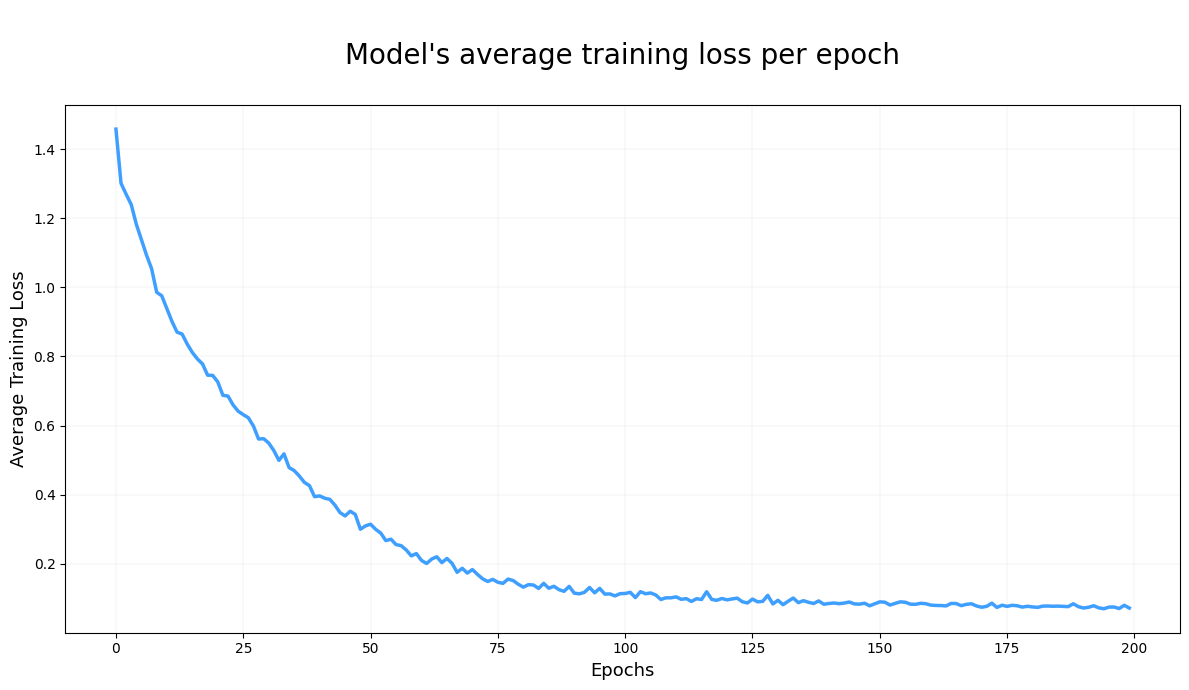

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(
    range(len(training_losses)), training_losses, 
    marker='.', markersize=0, 
    color=custom_hex_color('#3F9FFF'), 
    linewidth=2.5
)
ax.set_xlabel('Epochs', fontsize=13)
ax.set_ylabel('Average Training Loss', fontsize=13)
ax.set_title("\nModel's average training loss per epoch\n", fontsize=20)
ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)

plt.tight_layout()
plt.show()

### Αξιολόγηση (Testing)

Έχουμε πλέον εκπαιδεύσει το μοντέλο μας ως ένα βαθμό που το __μέσο σφάλμα εκπαίδευσης__ έχει πέσει σε ένα __ικανοποιητικό επίπεδο__. Ας ορίσουμε τώρα μία __συνάρτηση__ η οποία θα __αξιολογεί__ το εκπαιδευμένο μοντέλο μας και θα εκτιμάει την __επίδοσή__ του σε ξένα δεδομένα.

In [16]:
class F1_Score_Collector:
    """ Class that holds all the averages of F1-score metric. """
    
    def __init__(self, micro, macro, weighted):
        self.micro, self.macro = micro, macro
        self.weighted = weighted

    def __repr__(self):
        return f'(Micro: {self.micro}, Macro {self.macro}, Weighted: {self.weighted}'

In [17]:
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
        
def test_model(dataloader, criterion, nn_model):
    """ Tests a given neural network model, according to the given data 
        and returns the average loss, the accuracy and the confusion matrix 
        after the testing process """
    
    nn_model.eval() # Set the model to evaluation mode
    
    all_labels, all_predictions = [], []
    total_loss = 0.0
    
    with torch.no_grad():
        for data, labels in dataloader:
            
            # Move the data and the labels to device
            data, labels = data.to(device), labels.to(device)
            
            # Compute the predicted labels and get the loss
            predicted_labels = nn_model(data)
            loss = criterion(predicted_labels, labels)
            
            total_loss += loss.item() * data.size(0)
            
            # Get the most common prediction
            _, preds = torch.max(predicted_labels, 1)
            
            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            
    # Calculate the test metrics
    average_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    f1_score_micro = f1_score(all_labels, all_predictions, average='micro')
    f1_score_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_score_weighted = f1_score(all_labels, all_predictions, average='weighted')
    
    F1_score = F1_Score_Collector(f1_score_micro, f1_score_macro, f1_score_weighted)
    
    return average_loss, accuracy, conf_matrix, F1_score

Ας αξιολογήσουμε το εκπαιδευμένο μοντέλο και ας παρατηρήσουμε τις επιδόσεις του.

In [18]:
# Test the model
average_test_loss, accuracy, conf_matrix, F1_score = test_model(test_dataloader, loss_function, music_model)

# Print the results
print(f'Average Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'F1 score: {F1_score}')

Average Test Loss: 0.6631
Test Accuracy: 79.00%
F1 score: (Micro: 0.79, Macro 0.7844238765864383, Weighted: 0.7928501900260521


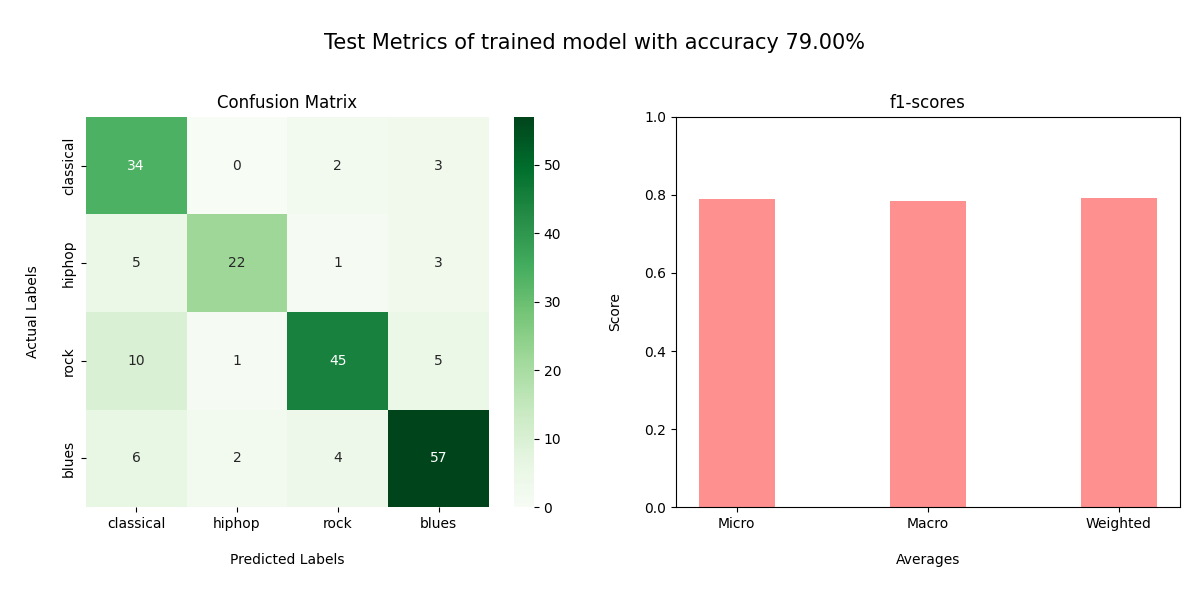

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

categories = ['classical', 'hiphop', 'rock', 'blues']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap=custom_cmap(plt.get_cmap('Greens')), 
    xticklabels=categories, yticklabels=categories, ax=axes[0]
)
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('\nPredicted Labels\n')
axes[0].set_ylabel('\nActual Labels\n')

axes[1].bar(
    ['Micro', 'Macro', 'Weighted'], 
    [F1_score.micro, F1_score.macro, F1_score.weighted], 
    color=custom_hex_color('#FF9090'),
    width=0.4
)
axes[1].set_ylim(0, 1)
axes[1].set_title('f1-scores')
axes[1].set_xlabel('\nAverages\n')
axes[1].set_ylabel('\nScore\n')

plt.suptitle(f'\nTest Metrics of trained model with accuracy {accuracy*100:.2f}%\n', fontsize=15)
plt.tight_layout()
plt.show()

Από την παραπάνω οπτικοποίηση του __confusion matrix__ και του __accuracy__ που δεχτήκαμε καταλαβαίνουμε πως το μοντέλο μας τα πηγαίνει αρκετά καλά σε ξένα δεδομένα. Ας αποθηκεύσουμε αυτό το μοντέλο.

In [20]:
import torch

# Save the model
torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/regular_model.pt'))

<hr>

## Επικύρωση Μοντέλου (Model Validation)

Θα θέλαμε παρόλα αυτά να εξετάσουμε __τι γίνεται__ πραγματικά κατά τη διαδικασία της εκπαίδευσης. Εδώ έρχονται να παίξουν ρόλο τα __validation data__ καθώς θα τα χρησιμοποιήσουμε για να __αξιολογήσουμε__ το μοντέλο μας __κατά τη διαδικασία της εκπαίδευσης__ και συγκεκριμένα __σε κάθε epoch__. Θα δημιουργήσουμε και πάλι ένα μοντέλο νευρωνικου δικτύου και θα το εκπαιδεύσουμε, αλλά αυτή τη φορά θα __αξιολογούμε__ το μοντέλο μας μετά από __κάθε μία εποχή εκπαίδευσης__ και θα αποθηκεύουμε τις επιστρεφόμενες μετρικές.

In [21]:
import torch.nn as nn
import torch.optim as optim

initialize_seed() # Initialize the randomness seed

training_losses = []
validation_losses = []
validation_accuracies = []
validation_conf_matrices = []
validation_f1_scores = []

music_model = CNN_Music_Identifier_Model().to(device) # Don't forget th move the model to the device

epochs = 200
learning_rate = 0.001
optimizer = optim.SGD(music_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Train the model for specific epochs
print(f"Model Training Process started | Device used: {device}")
for epoch in range(epochs):
    music_model, train_loss = train_for_one_epoch(optimizer, train_dataloader, loss_function, music_model)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{epochs}] | Training Loss: {train_loss}")
    
    testing_results = test_model(val_dataloader, loss_function, music_model)
    val_loss = testing_results[0]
    val_accuracy = testing_results[1]
    val_conf_matrix = testing_results[2]
    val_f1_score = testing_results[3]
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy * 100)
    validation_conf_matrices.append(val_conf_matrix)
    validation_f1_scores.append(val_f1_score)
    
print(f"Training Process Done.")

# Test the model
average_test_loss, accuracy, conf_matrix, F1_score = test_model(test_dataloader, loss_function, music_model)

# Print the results
print('------ Testing Results ------')
print(f'Average Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'F1-Score: {F1_score}')

Model Training Process started | Device used: cuda
Epoch [1/200] | Training Loss: 1.4578596711158753
Epoch [50/200] | Training Loss: 0.3097317887470126
Epoch [100/200] | Training Loss: 0.11361245212610811
Epoch [150/200] | Training Loss: 0.08434218991314993
Epoch [200/200] | Training Loss: 0.07205025369476062
Training Process Done.
------ Testing Results ------
Average Test Loss: 0.6631
Test Accuracy: 79.00%
F1-Score: (Micro: 0.79, Macro 0.7844238765864383, Weighted: 0.7928501900260521


Κατά τη διάρκεια της επικύρωσης αποθηκεύονται όλα τα confusion matrices για κάθε δεδομένη εποχή. Ας οπτικοποιήσουμε τις __4 πρώτες__ εκδοχές τους και τις __4 τελευταίες__.

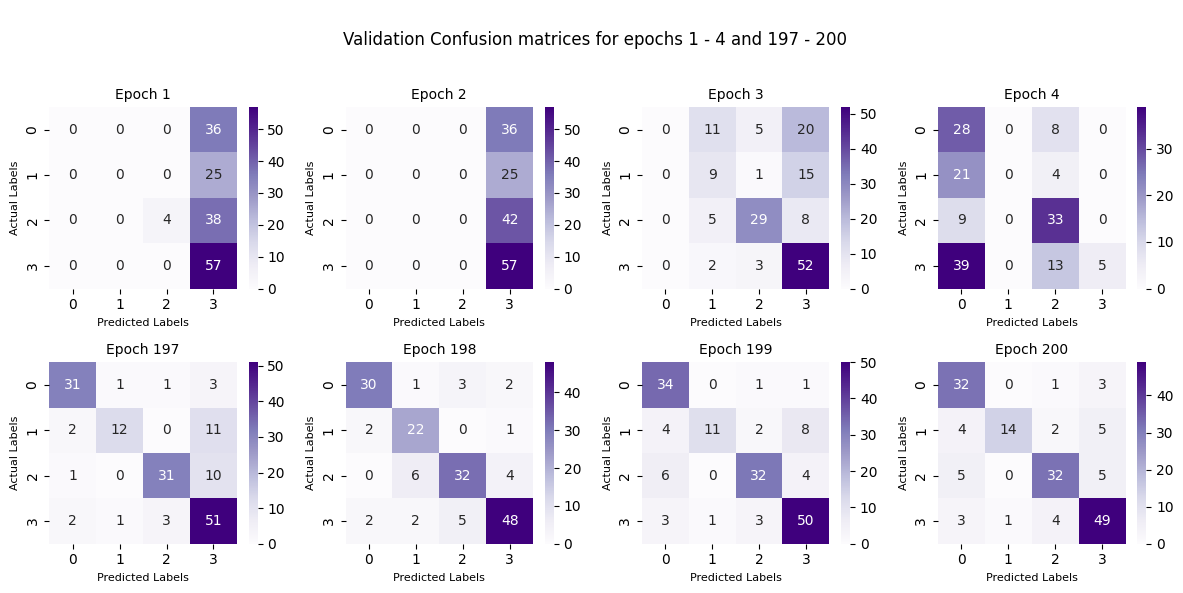

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

categories = ['classical', 'hiphop', 'rock', 'blues']

def plot_confusion_matrix(ax, conf_matrix, epoch):
    """ Plots a confusion matrix at the specific ax on the plot graph. """
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap(plt.get_cmap('Purples')), ax=ax)
    ax.set_title(f'Epoch {epoch}', fontsize=10)
    ax.set_xlabel('Predicted Labels', fontsize=8)
    ax.set_ylabel('Actual Labels', fontsize=8)
    
cols = 4
fig, axes = plt.subplots(2, cols, figsize=(12, 6))
cnt = 0
for j in range(cols):
    plot_confusion_matrix(axes[0][j], validation_conf_matrices[cnt], cnt + 1)
    cnt += 1
    
cnt = len(validation_conf_matrices) - 4

for j in range(cols):
    plot_confusion_matrix(axes[1][j], validation_conf_matrices[cnt], cnt + 1)
    cnt += 1

first_range = f'1 - {cols}'
second_range = f'{len(validation_conf_matrices) - 3} - {len(validation_conf_matrices)}'
plt.suptitle(f'\nValidation Confusion matrices for epochs {first_range} and {second_range}\n')
plt.tight_layout()
plt.show()

Από τα παραπάνω διαγράμματα των confusion matrices παρατηρούμε το πως βελτιώνεται το μοντέλο μας στο να προβλέπει δεδομένα από το σύνολο επικύρωσης. Ας οπτικοποιήσουμε τις πορείες των __σφαλμάτων εκπαίδευσης__ (Training Loss) και __επικύρωσης__ (Validation Loss), καθώς και τη πορεία του __validation accuracy__ σε όλες τις εποχές.

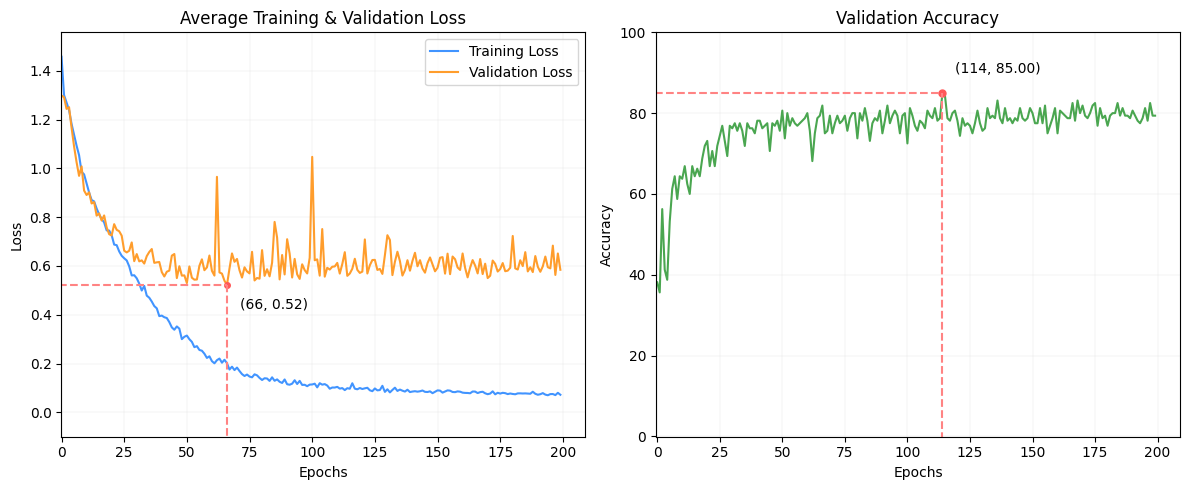

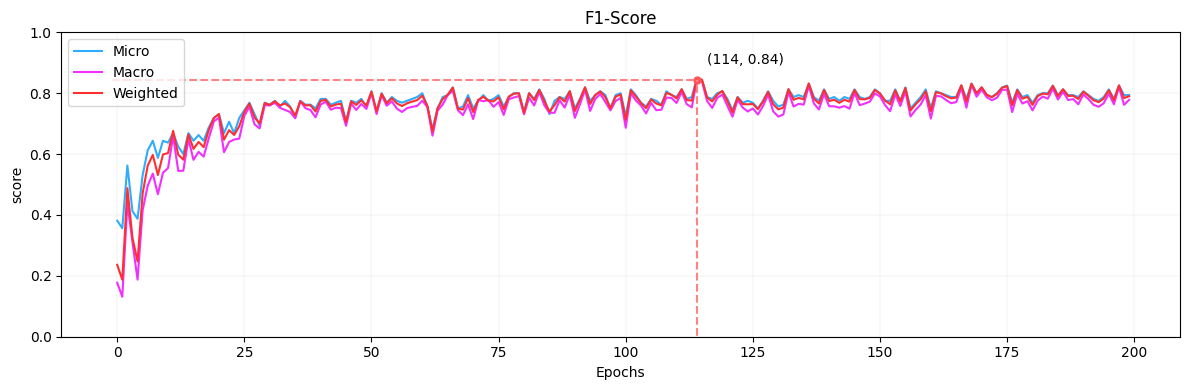

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def plot_training_and_validation_loss(ax) -> tuple[int, float]:
    """ Plots the Training and Validation Loss. Returns the (x, y) coordinates of 
        the minimum validation loss. """
    
    x1, y1 = range(len(training_losses)), training_losses
    x2, y2 = range(len(validation_losses)), validation_losses
    ax.plot(x1, y1, color=custom_hex_color('#4194FF'), label='Training Loss')
    ax.plot(x2, y2, label='Validation Loss', color=custom_hex_color('#FF9D2C'))
    ax.set_title('Average Training & Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    ax.set_ylim(-0.1, max(max(validation_losses), max(training_losses)) + 0.1)
    ax.set_xlim(-0.1)
    ax.legend()
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    
    return min(range(len(validation_losses)), key=validation_losses.__getitem__), min(validation_losses)

def plot_validation_accuracy(ax) -> tuple[int, float]:
    """ Plots the Validation Accuracy. Returns the (x, y) coordinates of
        the maximum validation accuracy. """
    
    x, y = range(len(validation_accuracies)), validation_accuracies
    ax.plot(x, y, color=custom_hex_color('#4AA650'))
    ax.set_title('Validation Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(-0.1, 100)
    ax.set_xlim(-0.5)
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    
    return max(range(len(validation_accuracies)), key=validation_accuracies.__getitem__), max(validation_accuracies)

def plot_minimum_validation_loss(ax, x, y):
    """ Plots a point to the minimum of Validation Loss. """
    
    ax.plot(x, y, 'o', markersize=4, color=custom_hex_color('#FF5858'), label='Minimum Validation Loss')
    ax.vlines(x=x, ymin=-1, ymax=y, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.hlines(y=y, xmin=-1, xmax=x, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.text(x + 5, y - 0.1, f'({x}, {y:.2f})')

def plot_maximum_validation_accuracy(ax, x, y):
    """ Plots a point to the maximum of of the Validation Accuracy. """
    
    ax.plot(x, y, 'o', markersize=5, color=custom_hex_color('#FF5858'))
    ax.vlines(x=x, ymin=-1, ymax=y, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.hlines(y=y, xmin=-1, xmax=x, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.text(x + 5, y + 5, f'({x}, {y:.2f})')

# Plot the training and validation losses, and the validation accuracy
min_val_loss_x, min_val_loss_y = plot_training_and_validation_loss(axes[0])
max_val_accuracy_x, max_val_accuracy_y = plot_validation_accuracy(axes[1])

# Plot the mimimum point of the validation loss, and the maximum point of the validation accuracy
plot_minimum_validation_loss(axes[0], min_val_loss_x, min_val_loss_y)
plot_maximum_validation_accuracy(axes[1], max_val_accuracy_x, max_val_accuracy_y)
    
plt.tight_layout()
plt.show()

def plot_f1_score(ax):
    """ Plots all the f1_score averages on the sampe graph. Also returns the (x, y) 
        coordinates of the max f1-score. """
    
    x_axis = range(len(val_f1_scores_micro))
    ax.plot(x_axis, val_f1_scores_micro, color=custom_hex_color('#2FACFF'), label='Micro')
    ax.plot(x_axis, val_f1_scores_macro, color=custom_hex_color('#F22FFF'), label='Macro')
    ax.plot(x_axis, val_f1_scores_weighted, color=custom_hex_color('#FF2F2F'), label='Weighted')
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    ax.set_title('F1-Score')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('score')
    ax.set_ylim(0, 1)
    ax.legend()
    
    return max(range(len(val_f1_scores_macro)), key=val_f1_scores_macro.__getitem__), max(val_f1_scores_macro)
    
def plot_max_f1_score(ax, x, y):
    """ Plots a point to the maximum f1-score. """
    
    ax.plot(x, y, 'o', markersize=5, color=custom_hex_color('#FF5858'))
    ax.vlines(x=x, ymin=-1, ymax=y, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.hlines(y=y, xmin=-1, xmax=x, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.text(x + 2, y + 0.05, f'({x}, {y:.2f})')
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    
val_f1_scores_micro = [score.micro for score in validation_f1_scores]
val_f1_scores_macro = [score.macro for score in validation_f1_scores]
val_f1_scores_weighted = [score.weighted for score in validation_f1_scores]

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
max_f1_score_x, max_f1_score_y = plot_f1_score(ax)
plot_max_f1_score(ax, max_f1_score_x, max_f1_score_y)

plt.tight_layout()
plt.show()

Από τα παραπάνω διαγράμματα παρατηρούμε πως παρά την ολική κάθοδο που επικρατεί στη συμπεριφορά του σφάλματος εκπαίδευσης, το __σφάλμα επικύρωσης__ (validation loss) παρουσιάζει αρχικά μία κάθοδο και αυτό αλλά πιο μετά δείχνει να ανεβαίνει με αργό ρυθμό. Επίσης η __ακρίβεια__ του μοντέλου κατα τη __διαδικασία επικύρωσης__ δείχνει να τείνει προς το __80%__. Το ίδιο ισχύει και για το __f1-score__ για όλα τα __average cases__. Ειδικά από ένα σημείο και μετά και τα 3 average cases του f1-score (Micro, Macro και Weighted) αρχίζουν και ταυτίζονται. Παρόλα αυτά υπάρχουν κάποια σκαμπανεβάσματα τόσο στο σφάλμα επικύρωσης όσο και στην ακρίβεια. Αυτό έχει ως αποτέλεσμα το ελάχιστο σφάλμα επικύρωσης και η μέγιστη ακρίβεια να __μην__ είναι πάντα στην τελευταία εποχή, όπου αυτό θα επιθυμούσαμε.

Ας οπτικοποιήσουμε τα __confusion matrices__ για τις __εποχές__ που αντιστοιχούν στα __συγκεκριμένα παραπάνω σημεία__.

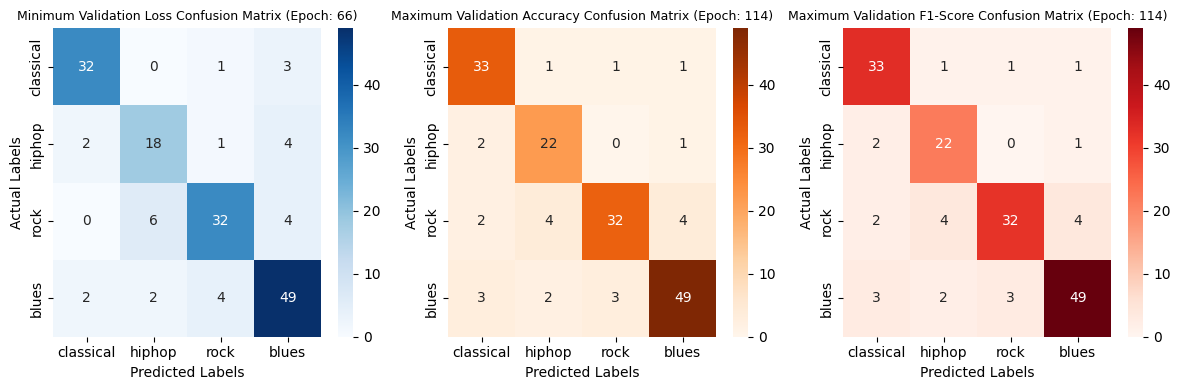

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

categories = ['classical', 'hiphop', 'rock', 'blues']

min_loss_epoch = min_val_loss_x
max_accuracy_epoch = max_val_accuracy_x
max_f1_score_epoch = max_f1_score_x

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.heatmap(
    validation_conf_matrices[min_loss_epoch], annot=True, fmt='d', cmap=custom_cmap(plt.get_cmap('Blues')),
    xticklabels=categories, yticklabels=categories, ax=axes[0]
)
axes[0].set_title(f'Minimum Validation Loss Confusion Matrix (Epoch: {min_loss_epoch})', fontsize=9)
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('Actual Labels')

sns.heatmap(
    validation_conf_matrices[max_accuracy_epoch], annot=True, fmt='d', cmap=custom_cmap(plt.get_cmap('Oranges')),
    xticklabels=categories, yticklabels=categories, ax=axes[1],
)
axes[1].set_title(f'Maximum Validation Accuracy Confusion Matrix (Epoch: {max_accuracy_epoch})', fontsize=9)
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('Actual Labels')

sns.heatmap(
    validation_conf_matrices[max_f1_score_epoch], annot=True, fmt='d', cmap=custom_cmap(plt.get_cmap('Reds')),
    xticklabels=categories, yticklabels=categories, ax=axes[2],
)
axes[2].set_title(f'Maximum Validation F1-Score Confusion Matrix (Epoch: {max_f1_score_epoch})', fontsize=9)
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('Actual Labels')

plt.tight_layout()
plt.show()

Από τα παραπάνω confusion matrices οι απόψεις διίστανται για το ποια εκδοχή του μοντέλου είναι καλύτερη. Γι' αυτό τον λόγω θα κάνουμε βαθύτερη ανάλυση και θα εξάγουμε συμπεράσματα και για τις δύο εκδοχές. 

## Αξιολόγηση μοντέλου για τις καλύτερες μετρικές επικύρωσης (Best Validation Metrics)

Θα ξεκινήσουμε __εκπαιδεύοντας__ το μοντέλο μας όπως κάναμε πριν αλλά αυτή τη φορά θα __αποθηκεύσουμε__ την έκδοση του μοντέλου στην οποία υπήρξε το __χαμηλότερο σφάλμα επικύρωσης__ καθώς και την έκδοση στην οποία υπήρξε η __μεγαλύτερη ακρίβεια__.

In [25]:
import torch.nn as nn
import torch.optim as optim

initialize_seed() # Initialize the randomness seed

training_losses = []
validation_losses = []
validation_accuracies = []
validation_conf_matrices = []

music_model = CNN_Music_Identifier_Model().to(device) # Don't forget th move the model to the device

epochs = 200
learning_rate = 0.001
optimizer = optim.SGD(music_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

min_loss_model_name = 'min_validation_loss_model.pt'
max_accuracy_model_name = 'max_validation_accuracy_model.pt'
max_f1_score_model_name = 'max_f1_score_model.pt'
min_validation_loss = 0.0
max_validation_accuracy = 0.0
max_f1_score = 0.0

# Train the model for specific epochs
print(f"Model Training Process started | Device used: {device}")
for epoch in range(epochs):
    music_model, train_loss = train_for_one_epoch(optimizer, train_dataloader, loss_function, music_model)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{epochs}] | Training Loss: {train_loss}")
    
    testing_results = test_model(val_dataloader, loss_function, music_model)
    val_loss = testing_results[0]
    val_accuracy = testing_results[1]
    val_conf_matrix = testing_results[2]
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy * 100)
    validation_conf_matrices.append(val_conf_matrix)
    
    # Update the validation loss as needed and store the current version of the model
    if epoch == 1:
        min_validation_loss = val_loss
    else:
        if val_loss < min_validation_loss:
            min_validation_loss = val_loss
            torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(min_loss_model_name)))
    
    # Update the validation accuracy as needed and store the current version of the model
    if val_accuracy > max_validation_accuracy:
        max_validation_accuracy = val_accuracy
        torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(max_accuracy_model_name)))
        
    # Update the validation f1-score as needed and store the current version of the model
    if val_f1_score.macro > max_f1_score:
        max_f1_score = val_f1_score.macro
        torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(max_f1_score_model_name)))
            
print(f"Training Process Done.")
print(f"Minimum Validation Loss found: {min_validation_loss}")
print(f"Maximum Validation Accuracy found: {max_validation_accuracy*100:.2f}%")
print(f"Maximum Validation F1-Score (Macro) found: {max_f1_score}")

Model Training Process started | Device used: cuda
Epoch [1/200] | Training Loss: 1.4578596711158753
Epoch [50/200] | Training Loss: 0.3097317887470126
Epoch [100/200] | Training Loss: 0.11361245212610811
Epoch [150/200] | Training Loss: 0.08434218991314993
Epoch [200/200] | Training Loss: 0.07205025369476062
Training Process Done.
Minimum Validation Loss found: 0.5224166199564934
Maximum Validation Accuracy found: 85.00%
Maximum Validation F1-Score (Macro) found: 0.7784132171387073


Έχοντας αποθηκέυσει και τις δύο εκδοχές του μοντέλου, ας τις __φορτώσουμε__ και ας __αξιολογήσουμε__ για να δούμε εάν μπορούμε να πετύχουμε __καλύτερη__ απόδοση σε ξένα δεδομένα, απ' ότι νωρίτερα.

In [26]:
import torch

min_validation_loss_model = CNN_Music_Identifier_Model().to(device)
max_validation_accuracy_model = CNN_Music_Identifier_Model().to(device)
max_validation_f1_score_model = CNN_Music_Identifier_Model().to(device)

# Load the models
min_validation_loss_model.load_state_dict(torch.load(data_folder + '/../models/min_validation_loss_model.pt'))
max_validation_accuracy_model.load_state_dict(torch.load(data_folder + '/../models/max_validation_accuracy_model.pt'))
max_validation_f1_score_model.load_state_dict(torch.load(data_folder + '/../models/max_f1_score_model.pt'))

# Test the models
results1 = test_model(test_dataloader, loss_function, min_validation_loss_model)
results2 = test_model(test_dataloader, loss_function, max_validation_accuracy_model)
results3 = test_model(test_dataloader, loss_function, max_validation_f1_score_model)

average_test_loss1, accuracy1, conf_matrix1, F1_score1 = results1
average_test_loss2, accuracy2, conf_matrix2, F1_score2 = results2
average_test_loss3, accuracy3, conf_matrix3, F1_score3 = results3

# Print the results
print(f'Average Test Loss for Minimum Validation Loss model: {average_test_loss1:.4f}')
print(f'Test Accuracy for Minimum Validation Loss model: {accuracy1 * 100:.2f}%')
print(f'Test F1-Score (Macro) for Minimum Validation Loss model: {F1_score1.macro:.4f}')
print()
print(f'Average Test Loss for Maximum Validation Accuracy model: {average_test_loss2:.4f}')
print(f'Test Accuracy for Maximum Validation Accuracy model: {accuracy2 * 100:.2f}%')
print(f'Test F1-Score (Macro) for Maximum Validation Accuracy model: {F1_score2.macro:.4f}')
print()
print(f'Average Test Loss for Maximum Validation F1-Score model: {average_test_loss3:.4f}')
print(f'Test Accuracy for Maximum Validation F1-Score model: {accuracy3 * 100:.2f}%')
print(f'Test F1-Score (Macro) for Maximum Validation F1-Score model: {F1_score3.macro:.4f}')

Average Test Loss for Minimum Validation Loss model: 0.5491
Test Accuracy for Minimum Validation Loss model: 79.50%
Test F1-Score (Macro) for Minimum Validation Loss model: 0.7839

Average Test Loss for Maximum Validation Accuracy model: 0.6067
Test Accuracy for Maximum Validation Accuracy model: 80.00%
Test F1-Score (Macro) for Maximum Validation Accuracy model: 0.7913

Average Test Loss for Maximum Validation F1-Score model: 1.2921
Test Accuracy for Maximum Validation F1-Score model: 36.00%
Test F1-Score (Macro) for Maximum Validation F1-Score model: 0.1531


Παρατηρούμε πως το __σφάλμα αξιολόγησης__ (test loss) στη περίπτωση του πρώτου μοντέλου είναι ελαφρά πιο κάτω από εκείνο που υπολογίσαμε νωρίτερα. Παρόλα αυτά η __ακρίβεια__ (accuracy) έχει πέσει και στις δύο περιπτώσεις. Επομένως μπορούμε να διατηρήσουμε το αρχικό μοντέλο ως εκείνο με το οποίο θα ασχοληθούμε στη συνέχεια.

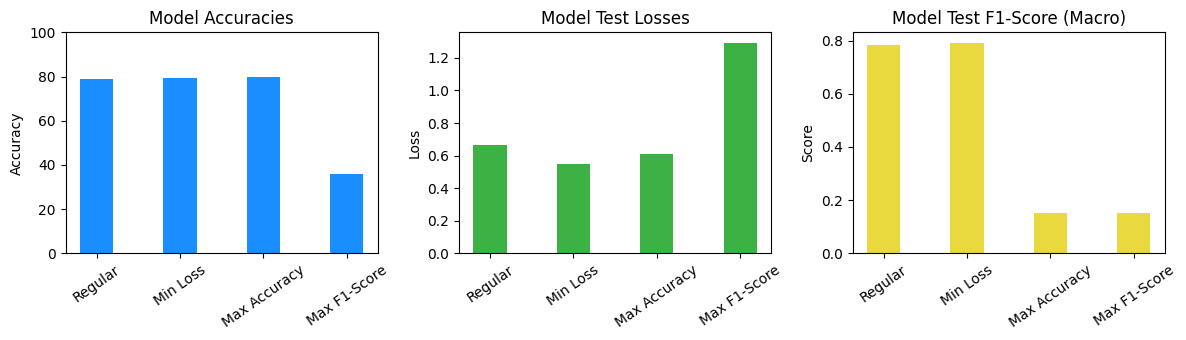

In [27]:
from matplotlib import pyplot as plt

x_axis = ['Regular', 'Min Loss', 'Max Accuracy', 'Max F1-Score']
y_axis1 = [accuracy*100, accuracy1*100, accuracy2*100, accuracy3*100]
y_axis2 = [average_test_loss, average_test_loss1, average_test_loss2, average_test_loss3]
y_axis3 = [F1_score1.macro, F1_score2.macro, F1_score3.macro, F1_score3.macro]

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
axes[0].bar(x_axis, y_axis1, color=custom_hex_color('#1A8DFF'), width=0.4)
axes[0].set_ylim(0, 100)
axes[0].set_title('Model Accuracies')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(4), x_axis, rotation=35)

axes[1].bar(x_axis, y_axis2, color=custom_hex_color('#3CB244'), width=0.4)
axes[1].set_title('Model Test Losses')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(4), x_axis, rotation=35)

axes[2].bar(x_axis, y_axis3, color=custom_hex_color('#E9D83E'), width=0.4)
axes[2].set_title('Model Test F1-Score (Macro)')
axes[2].set_ylabel('Score')
axes[2].set_xticks(range(4), x_axis, rotation=35)

plt.tight_layout()
plt.show()

## Χρήση Συναρτήσεων Ενεργοποίησης (Activation Functions) και Batch Normalization

Μέχρι στιγμής έχουμε πετύχει μία ακρίβεια μοντέλου η οποία φτάνει μέχει και __80.50%__. Μπορούμε άραγε να αυξήσουμε ακόμα περισσότερο αυτήν την ακρίβεια; Σε αυτό το σημείο θα εισάγουμε στην αρχιτεκτονική του μοντέλου μας τις [__συναρτήσεις ενεργοποίησης__][activation_functions_link] (Activation Functions) και συγκεκριμένα θα χρησιμοποιήσουμε την συνάρτηση [__ReLU__][relu_link]. Θα εφαρμόσουμε επίσης [__batch normalization__][batch_norm_link] σε __κάθε συνελικτικό επίπεδο__ του δικτύου μας. Θα δημιουργήσουμε επομένως ξανά το μοντέλο μας προσθέτοντας αυτήν την συνάρτηση ενεργοποίησης.

[activation_functions_link]: https://en.wikipedia.org/wiki/Activation_function
[relu_link]: https://builtin.com/machine-learning/relu-activation-function
[batch_norm_link]: https://en.wikipedia.org/wiki/Batch_normalization

In [48]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CNN_Music_Identifier_Model_v2(nn.Module):
    """ Class that represents a Convolution Neural Network designed for idetifying music category.
        This class includes also a ReLU activation function on the concolutional and dense layers. """
    
    KERNEL_SIZE = 5
    
    def __init__(self):
        """ Constructor of the Convolutional neural network. """
        
        super(CNN_Music_Identifier_Model_v2, self).__init__() # Initialize the neural network module
        
        # Initialize the Convolutional Layers of the the network
        self.conv1 = nn.Conv2d(1, 16, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv2 = nn.Conv2d(16, 32, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv3 = nn.Conv2d(32, 64, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv4 = nn.Conv2d(64, 128, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        
        # Define the bratch normalizations
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        
        # Define the pooling method
        self.max_pool = nn.MaxPool2d(2, 2)
        
        # Initialize the Fully Connected Layers of the network
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)
        
    def forward(self, x):
        """ Forward method of the neural network """

        # Apply the convolutional layers
        x = torch.unsqueeze(x, 1)
        x = self.max_pool(F.relu(self.bn1(self.conv1(x))))
        x = self.max_pool(F.relu(self.bn2(self.conv2(x))))
        x = self.max_pool(F.relu(self.bn3(self.conv3(x))))
        x = self.max_pool(F.relu(self.bn4(self.conv4(x))))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

Έχοντας προσθέσει την συνάρτηση ενεργοποίησης στην αρχιτεκτονική του μοντέλου ας το εκπαίδεύσουμε και ας δούμε τις επιδόσεις του.

In [61]:
import torch.nn as nn
import torch.optim as optim

initialize_seed() # Initialize the randomness seed

training_losses = []
validation_losses = []
validation_accuracies = []
validation_conf_matrices = []

music_model = CNN_Music_Identifier_Model_v2().to(device) # Don't forget th move the model to the device

epochs = 200
learning_rate = 0.001
optimizer = optim.SGD(music_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

min_loss_model_name = 'min_validation_loss_model.pt'
max_accuracy_model_name = 'max_validation_accuracy_model.pt'
max_f1_score_model_name = 'max_f1_score_model.pt'
min_validation_loss = 0.0
max_validation_accuracy = 0.0
max_f1_score = 0.0

# Train the model for specific epochs
print(f"Model Training Process started | Device used: {device}")
for epoch in range(epochs):
    music_model, train_loss = train_for_one_epoch(optimizer, train_dataloader, loss_function, music_model)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{epochs}] | Training Loss: {train_loss}")
    
    testing_results = test_model(val_dataloader, loss_function, music_model)
    val_loss = testing_results[0]
    val_accuracy = testing_results[1]
    val_conf_matrix = testing_results[2]
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy * 100)
    validation_conf_matrices.append(val_conf_matrix)
    
    # Update the validation loss as needed and store the current version of the model
    if epoch == 1:
        min_validation_loss = val_loss
    else:
        if val_loss < min_validation_loss:
            min_validation_loss = val_loss
            torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(min_loss_model_name)))
    
    # Update the validation accuracy as needed and store the current version of the model
    if val_accuracy > max_validation_accuracy:
        max_validation_accuracy = val_accuracy
        torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(max_accuracy_model_name)))
        
    # Update the validation f1-score as needed and store the current version of the model
    if val_f1_score.macro > max_f1_score:
        max_f1_score = val_f1_score.macro
        torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(max_f1_score_model_name)))
            
print(f"Training Process Done.")
print(f"Minimum Validation Loss found: {min_validation_loss}")
print(f"Maximum Validation Accuracy found: {max_validation_accuracy*100:.2f}%")
print(f"Maximum Validation F1-Score (Macro) found: {max_f1_score}")

# Test the model
average_test_loss, accuracy, conf_matrix, F1_score = test_model(test_dataloader, loss_function, music_model)

# Print the results
print('------ Testing Results ------')
print(f'Average Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'F1-Score: {F1_score}')

Model Training Process started | Device used: cuda
Epoch [1/200] | Training Loss: 1.3651694416999818
Epoch [50/200] | Training Loss: 0.7531964972615242
Epoch [100/200] | Training Loss: 0.147587170265615
Epoch [150/200] | Training Loss: 0.08486116129206493
Epoch [200/200] | Training Loss: 0.0645137143030297
Training Process Done.
Minimum Validation Loss found: 0.3941898986697197
Maximum Validation Accuracy found: 87.50%
Maximum Validation F1-Score (Macro) found: 0.7784132171387073
------ Testing Results ------
Average Test Loss: 0.4362
Test Accuracy: 87.00%
F1-Score: (Micro: 0.87, Macro 0.8680473397088304, Weighted: 0.8740599017384731


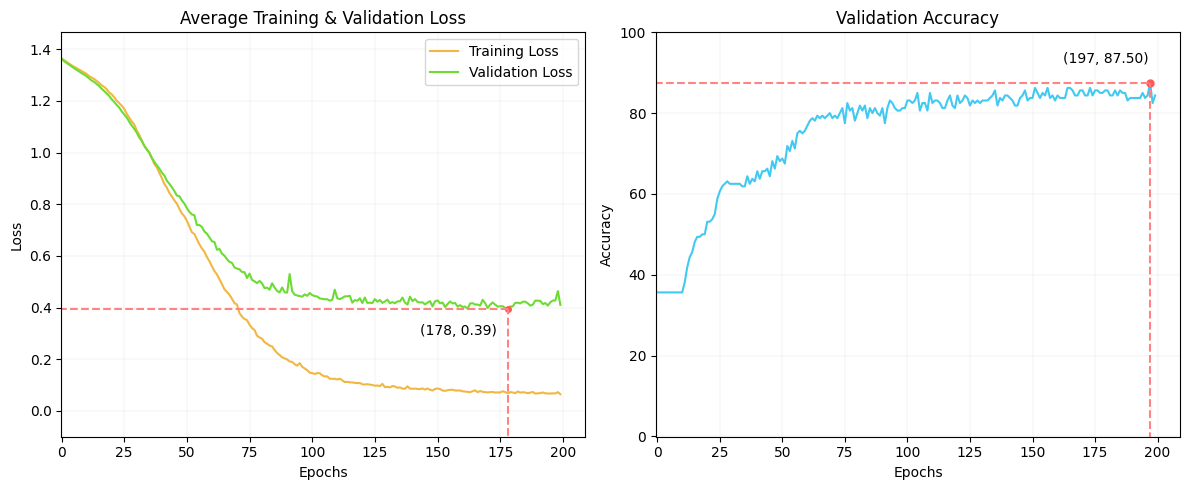

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def plot_training_and_validation_loss(ax) -> tuple[int, float]:
    """ Plots the Training and Validation Loss. Returns the (x, y) coordinates of 
        the minimum validation loss. """
    
    x1, y1 = range(len(training_losses)), training_losses
    x2, y2 = range(len(validation_losses)), validation_losses
    ax.plot(x1, y1, color=custom_hex_color('#F2B742'), label='Training Loss')
    ax.plot(x2, y2, label='Validation Loss', color=custom_hex_color('#6CDC33'))
    ax.set_title('Average Training & Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    ax.set_ylim(-0.1, max(max(validation_losses), max(training_losses)) + 0.1)
    ax.set_xlim(-0.1)
    ax.legend()
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    
    return min(range(len(validation_losses)), key=validation_losses.__getitem__), min(validation_losses)

def plot_validation_accuracy(ax) -> tuple[int, float]:
    """ Plots the Validation Accuracy. Returns the (x, y) coordinates of
        the maximum validation accuracy. """
    
    x, y = range(len(validation_accuracies)), validation_accuracies
    ax.plot(x, y, color=custom_hex_color('#42C9F2'))
    ax.set_title('Validation Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(-0.1, 100)
    ax.set_xlim(-0.5)
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    
    return max(range(len(validation_accuracies)), key=validation_accuracies.__getitem__), max(validation_accuracies)

def plot_minimum_validation_loss(ax, x, y):
    """ Plots a point to the minimum of Validation Loss. """
    
    ax.plot(x, y, 'o', markersize=4, color=custom_hex_color('#FF5858'), label='Minimum Validation Loss')
    ax.vlines(x=x, ymin=-1, ymax=y, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.hlines(y=y, xmin=-1, xmax=x, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.text(x - 35, y - 0.1, f'({x}, {y:.2f})')

def plot_maximum_validation_accuracy(ax, x, y):
    """ Plots a point to the maximum of of the Validation Accuracy. """
    
    ax.plot(x, y, 'o', markersize=5, color=custom_hex_color('#FF5858'))
    ax.vlines(x=x, ymin=-1, ymax=y, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.hlines(y=y, xmin=-1, xmax=x, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.text(x - 35, y + 5, f'({x}, {y:.2f})')

# Plot the training and validation losses, and the validation accuracy
min_val_loss_x, min_val_loss_y = plot_training_and_validation_loss(axes[0])
max_val_accuracy_x, max_val_accuracy_y = plot_validation_accuracy(axes[1])

# Plot the mimimum point of the validation loss, and the maximum point of the validation accuracy
plot_minimum_validation_loss(axes[0], min_val_loss_x, min_val_loss_y)
plot_maximum_validation_accuracy(axes[1], max_val_accuracy_x, max_val_accuracy_y)
    
plt.tight_layout()
plt.show()

Όπως παρατηρούμε η χρήση __συναρτήσεων ενεργοποίησης__ και __batch normalization__ λειτούργησε __θετικά__ στην βελτίωση του μοντέλου μας καθώς η ακρίβεια μεταβλήθηκε από __80.50%__ σε __περισσότερο__ από __85.00%__. Ας αποθηκεύσουμε την τρέχουσα έκδοση του μοντέλου μας.

In [63]:
import torch

# Save the model
torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/relu_batch_norm_model.pt'))

## Regulization

Στη συνέχεια θα δοκιμάσουμε να αμβλύνουμε τη διαφορά του train loss από το validation loss δοκιμάζοντας να προσθέσουμε
* __weight decay__ στον optimizer με τιμή __0.01__ και
* __dropout__ __0.5__ στα dense layers

Επομένως δημιουργώντας ξανά το μοντέλο και εκπαιδεύοντάς το έχουμε ότι:

In [80]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN_Music_Identifier_Model_v3(nn.Module):
    """ Class that represents a Convolution Neural Network designed for idetifying music category.
        This class includes also a ReLU activation function on the concolutional and dense layers
        and also it uses dropout as a regulization method. """
    
    KERNEL_SIZE = 5
    
    def __init__(self):
        """ Constructor of the Convolutional neural network. """
        
        super(CNN_Music_Identifier_Model_v3, self).__init__() # Initialize the neural network module
        
        # Initialize the Convolutional Layers of the the network
        self.conv1 = nn.Conv2d(1, 16, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv2 = nn.Conv2d(16, 32, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv3 = nn.Conv2d(32, 64, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        self.conv4 = nn.Conv2d(64, 128, CNN_Music_Identifier_Model.KERNEL_SIZE, padding=2)
        
        # Define the bratch normalizations
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        
        # Define the pooling method
        self.max_pool = nn.MaxPool2d(2, 2)
        
        # Initialize the Fully Connected Layers of the network
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)
        
        # Define the dropout methods
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        """ Forward method of the neural network """

        # Apply the convolutional layers
        x = torch.unsqueeze(x, 1)
        x = self.max_pool(F.relu(self.bn1(self.conv1(x))))
        x = self.max_pool(F.relu(self.bn2(self.conv2(x))))
        x = self.max_pool(F.relu(self.bn3(self.conv3(x))))
        x = self.max_pool(F.relu(self.bn4(self.conv4(x))))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply the fully connected layers
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.dropout3(F.relu(self.fc3(x)))
        x = self.fc4(x)

        return x

initialize_seed() # Initialize the randomness seed

training_losses = []
validation_losses = []
validation_accuracies = []
validation_conf_matrices = []

music_model = CNN_Music_Identifier_Model_v3().to(device) # Don't forget th move the model to the device

epochs = 200
learning_rate = 0.001
optimizer = optim.SGD(music_model.parameters(), lr=learning_rate, weight_decay=0.01)
loss_function = nn.CrossEntropyLoss()

min_loss_model_name = 'min_validation_loss_model.pt'
max_accuracy_model_name = 'max_validation_accuracy_model.pt'
max_f1_score_model_name = 'max_f1_score_model.pt'
min_validation_loss = 0.0
max_validation_accuracy = 0.0
max_f1_score = 0.0

# Train the model for specific epochs
print(f"Model Training Process started | Device used: {device}")
for epoch in range(epochs):
    music_model, train_loss = train_for_one_epoch(optimizer, train_dataloader, loss_function, music_model)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{epochs}] | Training Loss: {train_loss}")
    
    testing_results = test_model(val_dataloader, loss_function, music_model)
    val_loss = testing_results[0]
    val_accuracy = testing_results[1]
    val_conf_matrix = testing_results[2]
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy * 100)
    validation_conf_matrices.append(val_conf_matrix)
    
    # Update the validation loss as needed and store the current version of the model
    if epoch == 1:
        min_validation_loss = val_loss
    else:
        if val_loss < min_validation_loss:
            min_validation_loss = val_loss
            torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(min_loss_model_name)))
    
    # Update the validation accuracy as needed and store the current version of the model
    if val_accuracy > max_validation_accuracy:
        max_validation_accuracy = val_accuracy
        torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(max_accuracy_model_name)))
        
    # Update the validation f1-score as needed and store the current version of the model
    if val_f1_score.macro > max_f1_score:
        max_f1_score = val_f1_score.macro
        torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/' + str(max_f1_score_model_name)))
            
print(f"Training Process Done.")
print(f"Minimum Validation Loss found: {min_validation_loss}")
print(f"Maximum Validation Accuracy found: {max_validation_accuracy*100:.2f}%")
print(f"Maximum Validation F1-Score (Macro) found: {max_f1_score}")

# Test the model
average_test_loss, accuracy, conf_matrix, F1_score = test_model(test_dataloader, loss_function, music_model)

# Print the results
print('------ Testing Results ------')
print(f'Average Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'F1-Score: {F1_score}')

Model Training Process started | Device used: cuda
Epoch [1/200] | Training Loss: 1.3696001470088959
Epoch [50/200] | Training Loss: 1.0836818560957908
Epoch [100/200] | Training Loss: 0.5804160952568054
Epoch [150/200] | Training Loss: 0.23293133433908225
Epoch [200/200] | Training Loss: 0.14460301203653217
Training Process Done.
Minimum Validation Loss found: 0.38998534604907037
Maximum Validation Accuracy found: 88.75%
Maximum Validation F1-Score (Macro) found: 0.7784132171387073
------ Testing Results ------
Average Test Loss: 0.5293
Test Accuracy: 83.00%
F1-Score: (Micro: 0.83, Macro 0.8177952482300309, Weighted: 0.8294766972158277


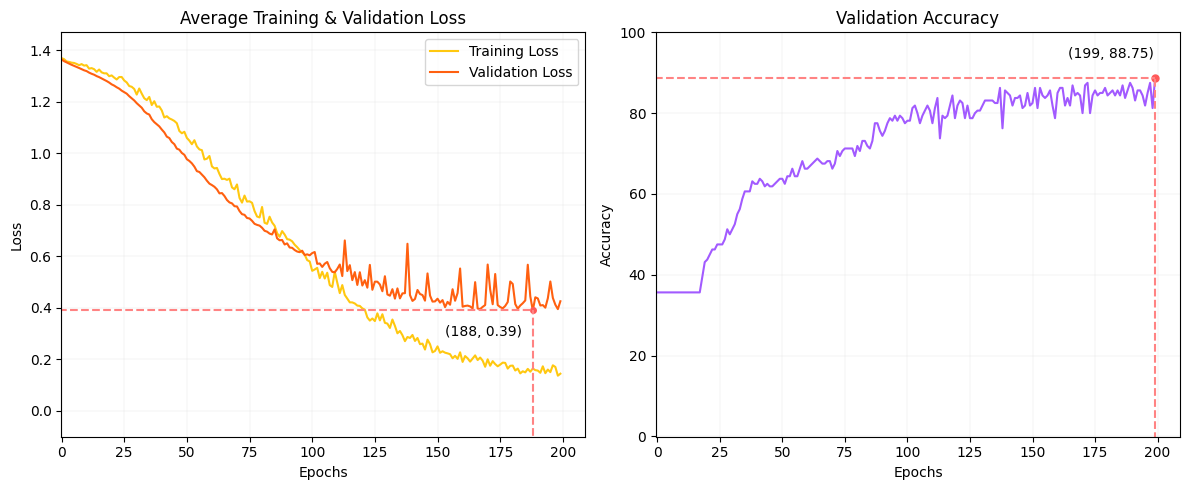

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def plot_training_and_validation_loss(ax) -> tuple[int, float]:
    """ Plots the Training and Validation Loss. Returns the (x, y) coordinates of 
        the minimum validation loss. """
    
    x1, y1 = range(len(training_losses)), training_losses
    x2, y2 = range(len(validation_losses)), validation_losses
    ax.plot(x1, y1, color=custom_hex_color('#FFC810'), label='Training Loss')
    ax.plot(x2, y2, label='Validation Loss', color=custom_hex_color('#FF6010'))
    ax.set_title('Average Training & Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    ax.set_ylim(-0.1, max(max(validation_losses), max(training_losses)) + 0.1)
    ax.set_xlim(-0.1)
    ax.legend()
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    
    return min(range(len(validation_losses)), key=validation_losses.__getitem__), min(validation_losses)

def plot_validation_accuracy(ax) -> tuple[int, float]:
    """ Plots the Validation Accuracy. Returns the (x, y) coordinates of
        the maximum validation accuracy. """
    
    x, y = range(len(validation_accuracies)), validation_accuracies
    ax.plot(x, y, color=custom_hex_color('#A25AFF'))
    ax.set_title('Validation Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(-0.1, 100)
    ax.set_xlim(-0.5)
    ax.grid(color=custom_hex_color('#DBDBDB'), linewidth=0.2)
    
    return max(range(len(validation_accuracies)), key=validation_accuracies.__getitem__), max(validation_accuracies)

def plot_minimum_validation_loss(ax, x, y):
    """ Plots a point to the minimum of Validation Loss. """
    
    ax.plot(x, y, 'o', markersize=4, color=custom_hex_color('#FF5858'), label='Minimum Validation Loss')
    ax.vlines(x=x, ymin=-1, ymax=y, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.hlines(y=y, xmin=-1, xmax=x, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.text(x - 35, y - 0.1, f'({x}, {y:.2f})')

def plot_maximum_validation_accuracy(ax, x, y):
    """ Plots a point to the maximum of of the Validation Accuracy. """
    
    ax.plot(x, y, 'o', markersize=5, color=custom_hex_color('#FF5858'))
    ax.vlines(x=x, ymin=-1, ymax=y, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.hlines(y=y, xmin=-1, xmax=x, color=custom_hex_color('#FF8383'), linestyle='--')
    ax.text(x - 35, y + 5, f'({x}, {y:.2f})')

# Plot the training and validation losses, and the validation accuracy
min_val_loss_x, min_val_loss_y = plot_training_and_validation_loss(axes[0])
max_val_accuracy_x, max_val_accuracy_y = plot_validation_accuracy(axes[1])

# Plot the mimimum point of the validation loss, and the maximum point of the validation accuracy
plot_minimum_validation_loss(axes[0], min_val_loss_x, min_val_loss_y)
plot_maximum_validation_accuracy(axes[1], max_val_accuracy_x, max_val_accuracy_y)
    
plt.tight_layout()
plt.show()

Παρατηρούμε πως παρόλο που καταφέραμε να μειώσουμε τη διαφορά του train loss και validation loss, η ακρίβεια του μοντέλου μας έπεσε. Παρόλα αυτά θα αποθηκεύσουμε και αυτήν την έκδοση του μοντέλου.

In [84]:
import torch

# Save the model
torch.save(music_model.state_dict(), resource_path(data_folder + '/../models/regulization_model.pt'))